# Load necessary packages

In [ ]:
# Import packages
import pandas as pd
from gseapy import enrichr
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import matplotlib.patches as mpatches
from pathlib import Path
import seaborn as sns
import re, gzip
import matplotlib as mpl
from scipy.stats import ttest_ind_from_stats
from owlready2 import get_ontology
from tqdm import tqdm

# Load Data files 

In [79]:
### Step 1: Load the data files 
denv_nsc_file = r"C:\Users\ruman\Desktop\Project 2025\Data\1. RNA seq data from VExD\Dengue Neural stem cell_GSE80434.txt"
zikv_nsc_file = r"C:\Users\ruman\Desktop\Project 2025\Data\1. RNA seq data from VExD\Zika Neural stem cell_GSE80434.txt"

# Skip metadata rows at top (Starts from line 4)
denv_nsc = pd.read_csv(denv_nsc_file, sep="\t", skiprows=4)
zikv_nsc = pd.read_csv(zikv_nsc_file, sep="\t", skiprows=4)

### Step 2: Select and rename relevant columns 
denv_nsc = denv_nsc[['Ensembl ID', 'Gene Symbol', 'log FC', 'adjusted p-val']]
denv_nsc.columns = ['ensembl_id', 'symbol', 'logFC_DENV_NSC', 'adjP_DENV_NSC']

zikv_nsc = zikv_nsc[['Ensembl ID', 'Gene Symbol', 'log FC', 'adjusted p-val']]
zikv_nsc.columns = ['ensembl_id', 'symbol', 'logFC_ZIKV_NSC', 'adjP_ZIKV_NSC']


# Filter significant DEG
- 'Up'   → significantly upregulated (adj P < 0.05 and logFC > 1.0)  
- 'Down' → significantly downregulated (adj P < 0.05 and logFC < -1.0)  
- 'NS'   → not significant (adj P ≥ 0.05 or |logFC| ≤ 1.0)

In [80]:
## Filter significant DEGs using thresholds
padj_thresh = 0.05  # FDR cutoff
fc_thresh = 1.0     # Minimum log2 fold-change

# Classify genes based on statistical significance and direction of regulation
denv_nsc['status_DENV'] = denv_nsc.apply(
    lambda x: 'Up' if x['adjP_DENV_NSC'] < padj_thresh and x['logFC_DENV_NSC'] > fc_thresh else
              'Down' if x['adjP_DENV_NSC'] < padj_thresh and x['logFC_DENV_NSC'] < -fc_thresh else 'NS', axis=1)

zikv_nsc['status_ZIKV'] = zikv_nsc.apply(
    lambda x: 'Up' if x['adjP_ZIKV_NSC'] < padj_thresh and x['logFC_ZIKV_NSC'] > fc_thresh else
              'Down' if x['adjP_ZIKV_NSC'] < padj_thresh and x['logFC_ZIKV_NSC'] < -fc_thresh else 'NS', axis=1)

In [81]:
denv_nsc.head(10)  # shows first 10 rows for DENV

,ensembl_id,symbol,logFC_DENV_NSC,adjP_DENV_NSC,status_DENV
0,ENSG00000000003,TSPAN6,-1.153772,0.012793,Down
1,ENSG00000000005,TNMD,-0.708279,1.000000,NS
2,ENSG00000000419,DPM1,0.928697,0.028525,NS
3,ENSG00000000457,SCYL3,0.098266,0.300833,NS
4,ENSG00000000460,C1orf112,-0.054144,0.660902,NS
5,ENSG00000000938,FGR,-1.154020,1.000000,NS
6,ENSG00000000971,CFH,-0.052196,1.000000,NS
7,ENSG00000001036,FUCA2,-1.014675,0.075441,NS
8,ENSG00000001084,GCLC,0.207750,0.114104,NS
9,ENSG00000001167,NFYA,-1.215054,0.000498,Down


In [82]:
zikv_nsc.head(10)  # shows first 10 rows for ZIKV

,ensembl_id,symbol,logFC_ZIKV_NSC,adjP_ZIKV_NSC,status_ZIKV
0,ENSG00000000003,TSPAN6,-0.288833,0.459107,NS
1,ENSG00000000005,TNMD,-0.115996,1.000000,NS
2,ENSG00000000419,DPM1,0.187860,0.218720,NS
3,ENSG00000000457,SCYL3,-0.003472,0.985670,NS
4,ENSG00000000460,C1orf112,-0.577029,0.024886,NS
5,ENSG00000000938,FGR,0.915261,1.000000,NS
6,ENSG00000000971,CFH,0.596130,1.000000,NS
7,ENSG00000001036,FUCA2,-0.209735,0.766151,NS
8,ENSG00000001084,GCLC,0.326148,0.049690,NS
9,ENSG00000001167,NFYA,-0.238331,0.316125,NS


# Save the files

In [83]:
# Save DENV data with DEG status
denv_nsc.to_csv("denv_nsc_classified.csv", index=False)

# Save ZIKV data with DEG status
zikv_nsc.to_csv("zikv_nsc_classified.csv", index=False)


# DEG in DENV and ZIKV

In [84]:
# Count total significant DEGs in DENV and ZIKV

total_deg_denv = denv_nsc[denv_nsc['status_DENV'] != 'NS']
total_deg_zikv = zikv_nsc[zikv_nsc['status_ZIKV'] != 'NS']

print(f"Total significant DEGs in DENV: {len(total_deg_denv)}")
print(f"Total significant DEGs in ZIKV: {len(total_deg_zikv)}")


    

Total significant DEGs in DENV: 3924
Total significant DEGs in ZIKV: 467


# Create DEG gene lists (all, up, down)

In [85]:
# All significant DEGs (gene symbols)
deg_denv_all = total_deg_denv['symbol'].unique().tolist()
deg_zikv_all = total_deg_zikv['symbol'].unique().tolist()

# Upregulated only
deg_denv_up = total_deg_denv[total_deg_denv['status_DENV'] == 'Up']['symbol'].unique().tolist()
deg_zikv_up = total_deg_zikv[total_deg_zikv['status_ZIKV'] == 'Up']['symbol'].unique().tolist()

# Downregulated only
deg_denv_down = total_deg_denv[total_deg_denv['status_DENV'] == 'Down']['symbol'].unique().tolist()
deg_zikv_down = total_deg_zikv[total_deg_zikv['status_ZIKV'] == 'Down']['symbol'].unique().tolist()

# Show counts
print(f"DENV: {len(deg_denv_up)} up, {len(deg_denv_down)} down")
print(f"ZIKV: {len(deg_zikv_up)} up, {len(deg_zikv_down)} down")


DENV: 2301 up, 1376 down
ZIKV: 194 up, 244 down


# Overlapping DEGS

In [86]:
# Remove NaNs from gene symbol lists
deg_denv_all = total_deg_denv['symbol'].dropna().unique().tolist()
deg_zikv_all = total_deg_zikv['symbol'].dropna().unique().tolist()

# Step: Find overlapping genes
set_denv = set(deg_denv_all)
set_zikv = set(deg_zikv_all)

overlapping_degs = set_denv & set_zikv
overlapping_degs_list = sorted(list(overlapping_degs))


# Display results
print(f"Total overlapping DEGs between DENV and ZIKV: {len(overlapping_degs_list)}")
print(overlapping_degs_list)

# Save to text file
with open("overlapping_degs_denv_zikv.txt", "w") as f:
    f.write("\n".join(overlapping_degs_list))
    


Total overlapping DEGs between DENV and ZIKV: 353
['ABHD16B', 'AC003005.1', 'AC008013.3', 'AC009533.2', 'AC024940.1', 'AC069499.1', 'AC087632.2', 'AC091057.6', 'AC135279.2', 'AC141557.1', 'ACBD7', 'ACVR1', 'AIF1L', 'AKNAD1', 'AL136531.2', 'AL445665.1', 'AL450124.1', 'AL845321.1', 'AMYH02020865.1', 'ANLN', 'AP000553.5', 'AQP7', 'ARHGAP23', 'ARHGEF39', 'ARHGEF6', 'ARMC3', 'ASB16', 'ASF1B', 'ASNS', 'ASPM', 'ATF3', 'AURKA', 'AURKB', 'AURKC', 'BBC3', 'BHLHE40', 'BIRC5', 'BNIP3P17', 'BRCA1', 'BRCA2', 'BTBD17', 'BUB1B', 'C21orf58', 'C2CD2L', 'C6orf118', 'CARS1', 'CBX4', 'CCDC81', 'CCNB1', 'CCNB2', 'CCNE2', 'CCT6P1', 'CCT6P3', 'CD37', 'CDC20', 'CDC45', 'CDCA3', 'CDCA5', 'CDCA7', 'CDK1', 'CDK2', 'CDKN2AIP', 'CDKN2C', 'CEBPB', 'CENPF', 'CENPI', 'CENPK', 'CENPM', 'CENPN', 'CENPO', 'CEP55', 'CHAC1', 'CHAF1A', 'CHRDL1', 'CIART', 'CIP2A', 'CKS1B', 'CLEC4A', 'CLSPN', 'CMTM3', 'COL3A1', 'CREB3L1', 'CREBRF', 'CSRNP1', 'CTH', 'DBF4B', 'DDIT3', 'DDIT4', 'DDX11', 'DDX11L2', 'DDX12P', 'DEPDC1B', 'DGCR5', '

#### Identify shared up- and downregulated genes that are involved in:

    - DNA replication/repair
    - Inflammatory response
    - Neurodevelopmental processes
    - ER stress/ERAD/chaperone-related pathways

- It uses GO Biological Process terms via Enrichr, filters for relevant pathway terms using keyword matching.

In [ ]:
# Import packages
# import pandas as pd
# from gseapy import enrichr

# Load overlapping DEGs
with open("overlapping_degs_denv_zikv.txt") as f:
    overlapping_genes = [line.strip() for line in f if line.strip()]
print(f"Total overlapping DEGs: {len(overlapping_genes)}")

# GO Enrichment
results = enrichr(
    gene_list=overlapping_genes,
    gene_sets='GO_Biological_Process_2021',
    organism='Human',
    outdir=None,
    cutoff=0.05
)
enriched_df = results.res2d.copy()

# Expanded keywords
keywords = [
    "dna replication", "dna repair", "neuro", "axon", "synapse",
    "neuron", "inflammatory", "inflammation", "endoplasmic reticulum",
    "er stress", "er-associated degradation", "chaperone", "refolding",
    "regulation of defense response", "regulation of mapk cascade",
    "cell chemotaxis", "paf1c", "interferon", "sec61", "ankle2",
    "microcephaly", "apoptosis"
]

# Filter enriched terms
relevant_terms = enriched_df[enriched_df['Term'].str.lower().str.contains('|'.join(keywords))]
print(f"Found {len(relevant_terms)} enriched GO terms")

# Get associated genes from enriched terms
relevant_genes = set()
for genes in relevant_terms['Genes']:
    relevant_genes.update(genes.split(';'))

filtered_shared_deg = [g for g in overlapping_genes if g in relevant_genes]

# Load DEG data
denv_raw = pd.read_csv("Dengue Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)
zikv_raw = pd.read_csv("Zika Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)

# Keep necessary columns
denv = denv_raw[['Gene Symbol', 'log FC', 'adjusted p-val']].rename(
    columns={'log FC': 'logFC_DENV', 'adjusted p-val': 'adjP_DENV'})
zikv = zikv_raw[['Gene Symbol', 'log FC', 'adjusted p-val']].rename(
    columns={'log FC': 'logFC_ZIKV', 'adjusted p-val': 'adjP_ZIKV'})

# Merge DENV and ZIKV
merged = pd.merge(denv, zikv, on='Gene Symbol')
merged = merged[merged['Gene Symbol'].isin(filtered_shared_deg)]

# Classify regulatory direction
def classify(row):
    if row['logFC_DENV'] > 1 and row['logFC_ZIKV'] > 1:
        return 'Shared Up'
    elif row['logFC_DENV'] < -1 and row['logFC_ZIKV'] < -1:
        return 'Shared Down'
    elif row['logFC_DENV'] > 1 and row['logFC_ZIKV'] < -1:
        return 'DENV Up, ZIKV Down'
    elif row['logFC_DENV'] < -1 and row['logFC_ZIKV'] > 1:
        return 'DENV Down, ZIKV Up'
    else:
        return 'Other'

merged['category'] = merged.apply(classify, axis=1)

# Save to 4 output files
shared_up = merged[merged['category'] == 'Shared Up']
shared_down = merged[merged['category'] == 'Shared Down']
denv_up_zikv_down = merged[merged['category'] == 'DENV Up, ZIKV Down']
denv_down_zikv_up = merged[merged['category'] == 'DENV Down, ZIKV Up']

shared_up.to_csv("1_all_shared_upregulated_genes.csv", index=False)
shared_down.to_csv("2_all_shared_downregulated_genes.csv", index=False)
denv_up_zikv_down.to_csv("3_genes_up_in_DENV_down_in_ZIKV.csv", index=False)
denv_down_zikv_up.to_csv("4_genes_down_in_DENV_up_in_ZIKV.csv", index=False)

# Print summary
print("\n===== DEG Summary =====")
print(f"Total filtered overlapping DEGs: {len(filtered_shared_deg)}")
print(f"Shared Up-regulated: {len(shared_up)}")
print(f"Shared Down-regulated: {len(shared_down)}")
print(f"DENV Up, ZIKV Down: {len(denv_up_zikv_down)}")
print(f"DENV Down, ZIKV Up: {len(denv_down_zikv_up)}")


Total overlapping DEGs: 353
Found 136 enriched GO terms

===== DEG Summary =====
Total filtered overlapping DEGs: 117
Shared Up-regulated: 42
Shared Down-regulated: 75
DENV Up, ZIKV Down: 0
DENV Down, ZIKV Up: 0


##### STATISTICS #######

## Total DEGs in DENV and ZIKV in hNPC cells:
DENV: 2301 up, 1376 down
ZIKV: 194 up, 244 down

## Total number of Counts in total Shared DEGs in hNPC cells in DENV and ZIKV:
Gene counts per group:
Shared Upregulated: 150 genes
Shared Downregulated: 201 genes
UP-DENV & Down-ZIKV: 1 genes
Down-DENV & Up-ZIKV: 1 genes

## Unique DEG counts in hNPC cells:
DENV Upregulated: 2149
DENV Downregulated: 1173
ZIKV Upregulated: 42
ZIKV Downregulated: 41

## DENV (hepatoma) DEG Summary ===
Total DEGs: 335
Upregulated: 269
Downregulated: 66

## DEG Overlaps ===
DENV (hepatoma) ∩ ZIKV (hNPC): 40 genes
DENV (hepatoma) ∩ DENV (hNPC): 173 genes


# Venn Diagram of the Statistics

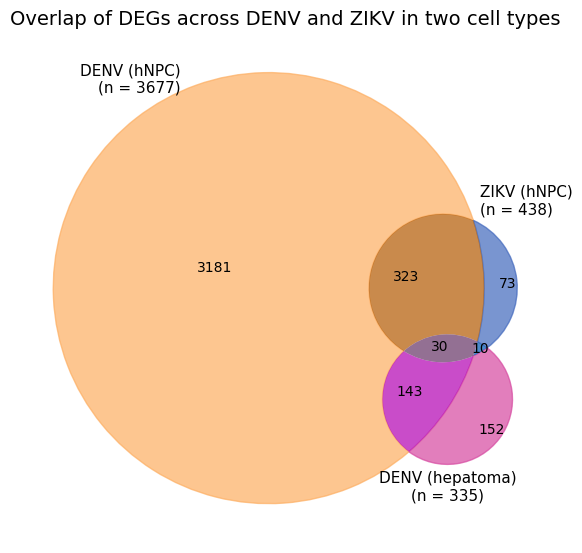

In [ ]:

# Define DEG counts from your data 
total_denv_npc = 3677
total_zikv_npc = 436
total_denv_hep = 335

# Overlaps
overlap_denv_zikv = 353
overlap_denv_hep_zikv = 40
overlap_denv_hep_denv_npc = 173
triple_overlap = 30  # estimated overlap among all three

# === Calculate unique and pairwise intersections (excluding triple) ===
only_denv_npc = total_denv_npc - (overlap_denv_zikv + overlap_denv_hep_denv_npc - triple_overlap)
only_zikv_npc = total_zikv_npc - (overlap_denv_zikv + overlap_denv_hep_zikv - triple_overlap)
only_denv_hep = total_denv_hep - (overlap_denv_hep_denv_npc + overlap_denv_hep_zikv - triple_overlap)

denv_zikv_only = overlap_denv_zikv - triple_overlap
denv_hep_zikv_only = overlap_denv_hep_zikv - triple_overlap
denv_hep_denv_npc_only = overlap_denv_hep_denv_npc - triple_overlap

# === Prepare Venn counts ===
venn_counts = {
    '100': only_denv_npc,
    '010': only_zikv_npc,
    '001': only_denv_hep,
    '110': denv_zikv_only,
    '101': denv_hep_denv_npc_only,
    '011': denv_hep_zikv_only,
    '111': triple_overlap
}

# === Plot ===
plt.figure(figsize=(6,6))
venn = venn3(subsets=venn_counts, set_labels=('DENV (hNPC)\n(n = 3677)', 'ZIKV (hNPC)\n(n = 438)', 'DENV (hepatoma)\n(n = 335)'))

# Move the first label (left set) closer to the circle
label = venn.set_labels[0]  # Index 0 = first label
x, y = label.get_position()
label.set_position((x + 0.05, y - 0.05))  # Adjust these values as needed

# Set font size for each set label
for label in venn.set_labels:
    if label:
        label.set_fontsize(11)  
# Customize circle colors
venn.get_patch_by_id('100').set_color('#fdae61')  # orange
venn.get_patch_by_id('010').set_color("#4168bd")  # light blue
venn.get_patch_by_id('001').set_color("#D648A0")  # red


# Set transparency and label font size
for patch in venn.patches:
    if patch: patch.set_alpha(0.7)

for label in venn.subset_labels:
    if label: label.set_fontsize(10)

# === Title and layout ===
plt.title("Overlap of DEGs across DENV and ZIKV in two cell types", fontsize=14)
plt.tight_layout()
plt.show()


# Create MA Plots (DENV and ZIKV)

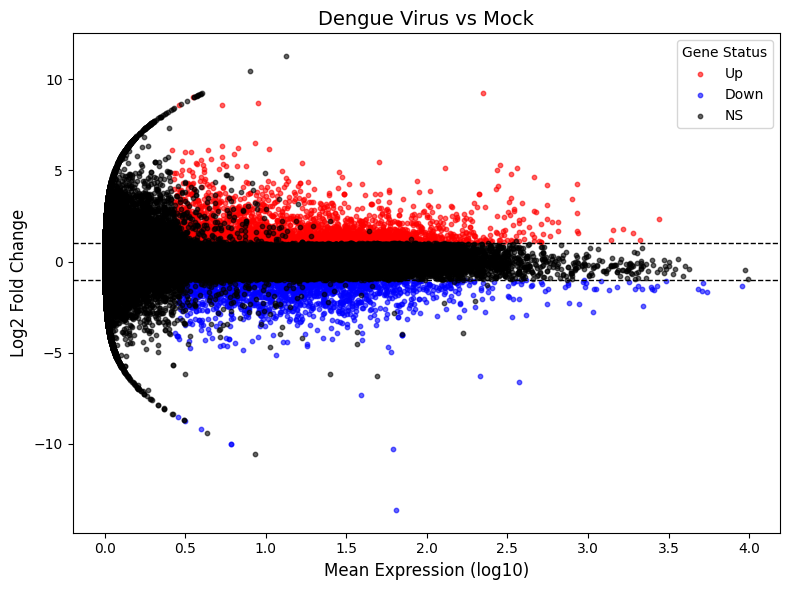

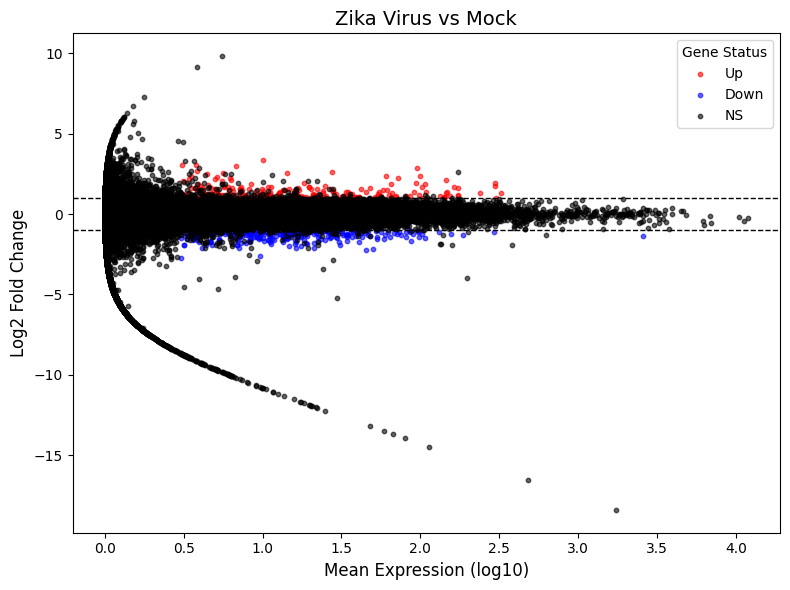

In [ ]:
# Parse the raw files

def read_tsv(path):
    # Skips the '#...' metadata lines and uses the next line as the header
    return pd.read_csv(path, sep="\t", comment="#", engine="python")

# Load the two raw tables (these already contain means + logFC)
denv_nsc = read_tsv(denv_nsc_file)
zikv_nsc = read_tsv(zikv_nsc_file)

# Compute mean expression (log10 of the average of the two condition means)
for df in (denv_nsc, zikv_nsc):
    df["mean_expr"] = np.log10(df[["Uninfected mean","Infected mean"]].mean(axis=1) + 1)

# Standardise column names expected by your plotting code
# (your files call it "log FC" and "adjusted p-val")
denv_nsc = denv_nsc.rename(columns={"log FC":"log2FC", "adjusted p-val":"FDR"})
zikv_nsc = zikv_nsc.rename(columns={"log FC":"log2FC", "adjusted p-val":"FDR"})

# If you don't already have a 'status' column, create one
def add_status(df, fc_col="log2FC", fdr_col="FDR", fc_thr=1.0, fdr_thr=0.05):
    up = (df[fc_col] >= fc_thr) & (df[fdr_col] <= fdr_thr)
    down = (df[fc_col] <= -fc_thr) & (df[fdr_col] <= fdr_thr)
    return np.where(up, "Up", np.where(down, "Down", "NS"))

for df in (denv_nsc, zikv_nsc):
    if "status" not in df.columns:
        df["status"] = add_status(df)

# Plotting (unchanged)
def plot_ma(df, virus_name):
    plt.figure(figsize=(8, 6))
    colors = {"Up": "red", "Down": "blue", "NS": "black"}
    for status, color in colors.items():
        subset = df[df["status"] == status]
        plt.scatter(subset["mean_expr"], subset["log2FC"], label=status, color=color, s=10, alpha=0.6)
    plt.axhline(y=1.0, color="black", linestyle="--", linewidth=1)
    plt.axhline(y=-1.0, color="black", linestyle="--", linewidth=1)
    plt.title(f"{virus_name} vs Mock", fontsize=14)
    plt.xlabel("Mean Expression (log10)", fontsize=12)
    plt.ylabel("Log2 Fold Change", fontsize=12)
    plt.legend(title="Gene Status", frameon=True)
    plt.grid(False)
    plt.gca().set_facecolor("white")
    plt.tight_layout()
    plt.show()

plot_ma(denv_nsc, "Dengue Virus")
plot_ma(zikv_nsc, "Zika Virus")


# Create scatter plot

Saved plot to: denv_zikv_scatter.png
Saved merged table to: merged_DENV_ZIKV_NSC.csv
Counts by category:
category
Virus-specific DEGs      40115
Shared Down-regulated      216
Shared Up-regulated        157
Name: count, dtype: int64


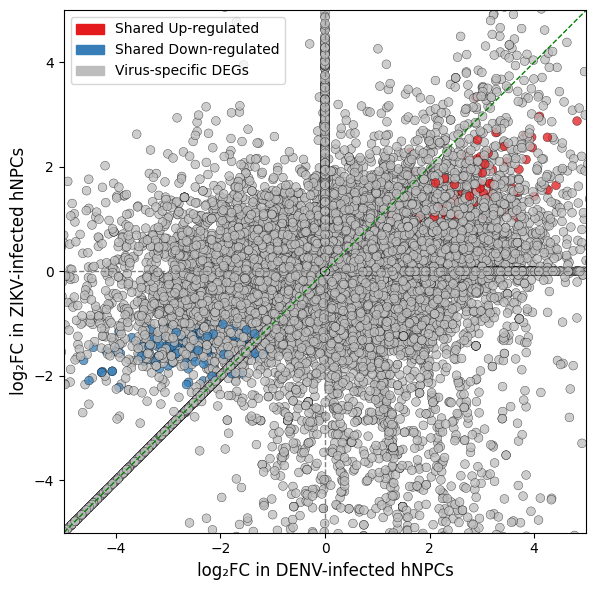

In [ ]:
# DENV vs ZIKV scatter from raw TSVs 
zikv_path = Path(r"Zika Neural stem cell_GSE80434.txt")  
denv_path = Path(r"Dengue Neural stem cell_GSE80434.txt") 
out_dir   = Path(r"")                           # where outputs will be saved

padj_thresh = 0.05
logfc_thresh = 1.0  # absolute log2FC threshold for calling Up/Down
xlim = (-5, 5)
ylim = (-5, 5)


out_dir.mkdir(parents=True, exist_ok=True)

# Read TSVs, skipping comment lines (starting with '#') 
zikv = pd.read_csv(zikv_path, sep="\t", comment="#")
denv = pd.read_csv(denv_path, sep="\t", comment="#")

# Rename column names 
# Columns: 'Ensembl ID', 'Gene Symbol', 'log FC', 'adjusted p-val'
zikv = zikv.rename(columns={
    "Ensembl ID": "ensembl_id",
    "Gene Symbol": "gene_symbol_zikv",
    "log FC": "logFC_ZIKV_NSC",
    "adjusted p-val": "adjP_ZIKV_NSC"
})
denv = denv.rename(columns={
    "Ensembl ID": "ensembl_id",
    "Gene Symbol": "gene_symbol_denv",
    "log FC": "logFC_DENV_NSC",
    "adjusted p-val": "adjP_DENV_NSC"
})

required_z = ["ensembl_id", "gene_symbol_zikv", "logFC_ZIKV_NSC", "adjP_ZIKV_NSC"]
required_d = ["ensembl_id", "gene_symbol_denv", "logFC_DENV_NSC", "adjP_DENV_NSC"]
missing = [c for c in required_z if c not in zikv.columns] + [c for c in required_d if c not in denv.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}\n"
                   f"Available ZIKV: {zikv.columns.tolist()}\n"
                   f"Available DENV: {denv.columns.tolist()}")

zikv = zikv[required_z].copy()
denv = denv[required_d].copy()

# Ensure numeric types for logFC and adjP
for c in ["logFC_ZIKV_NSC", "adjP_ZIKV_NSC"]:
    zikv[c] = pd.to_numeric(zikv[c], errors="coerce")
for c in ["logFC_DENV_NSC", "adjP_DENV_NSC"]:
    denv[c] = pd.to_numeric(denv[c], errors="coerce")

# Inner join on Ensembl ID (genes present in both) 
merged_all = pd.merge(zikv, denv, on="ensembl_id", how="inner")

# One gene symbol column (prefer ZIKV name, else DENV) 
merged_all["Gene_Symbol"] = merged_all["gene_symbol_zikv"].fillna(merged_all["gene_symbol_denv"])

# Define significance & direction per virus 
def status(logfc, padj, fc_thr=logfc_thresh, p_thr=padj_thresh):
    if pd.isna(logfc) or pd.isna(padj):
        return "NS"
    if padj < p_thr and logfc > fc_thr:
        return "Up"
    if padj < p_thr and logfc < -fc_thr:
        return "Down"
    return "NS"

merged_all["status_ZIKV"] = [status(l, p) for l, p in zip(merged_all["logFC_ZIKV_NSC"], merged_all["adjP_ZIKV_NSC"])]
merged_all["status_DENV"] = [status(l, p) for l, p in zip(merged_all["logFC_DENV_NSC"], merged_all["adjP_DENV_NSC"])]

# Categorize points for coloring 
def categorize(row):
    if row["status_ZIKV"] == "Up" and row["status_DENV"] == "Up":
        return "Shared Up-regulated"
    if row["status_ZIKV"] == "Down" and row["status_DENV"] == "Down":
        return "Shared Down-regulated"
    return "Virus-specific DEGs"

merged_all["category"] = merged_all.apply(categorize, axis=1)

# Colors 
highlight_colors = {
    "Shared Up-regulated": "#E41A1C",   # red
    "Shared Down-regulated": "#377EB8", # blue
}
merged_all["plot_color"] = merged_all["category"].map(highlight_colors).fillna("#BDBDBD")  # grey

# Drop rows missing coordinates 
plot_df = merged_all.dropna(subset=["logFC_DENV_NSC", "logFC_ZIKV_NSC"])

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(
    plot_df["logFC_DENV_NSC"],
    plot_df["logFC_ZIKV_NSC"],
    c=plot_df["plot_color"].values,
    edgecolor="black",
    linewidth=0.3,
    s=40,
    alpha=0.75
)

# Reference lines and diagonal
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.axvline(0, linestyle="--", color="gray", linewidth=1)
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], linestyle="--", color="green", linewidth=1)

plt.xlabel("log\u2082FC in DENV-infected hNPCs", fontsize=12)
plt.ylabel("log\u2082FC in ZIKV-infected hNPCs", fontsize=12)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.gca().set_aspect("equal", "box")

# Legend
legend_elements = [
    mpatches.Patch(color="#E41A1C", label="Shared Up-regulated"),
    mpatches.Patch(color="#377EB8", label="Shared Down-regulated"),
    mpatches.Patch(color="#BDBDBD", label="Virus-specific DEGs"),
]
plt.legend(handles=legend_elements, loc="upper left", frameon=True)
plt.tight_layout()

# Save outputs 
plot_path = out_dir / "denv_zikv_scatter.png"
csv_path  = out_dir / "merged_DENV_ZIKV_NSC.csv"
plt.savefig(plot_path, dpi=300)
merged_all.to_csv(csv_path, index=False)

# Console summary 
print("Saved plot to:", plot_path)
print("Saved merged table to:", csv_path)
print("Counts by category:")
print(merged_all["category"].value_counts(dropna=False))


In [104]:
shared = merged_all[merged_all['category'].isin(['Shared Up-regulated', 'Shared Down-regulated'])]
shared = shared[['logFC_DENV_NSC', 'logFC_ZIKV_NSC']].dropna()
r_shared, p_shared = pearsonr(shared['logFC_DENV_NSC'], shared['logFC_ZIKV_NSC'])
print(f"Shared-only: r = {r_shared:.4f}, p = {p_shared:.3e}, n = {len(shared)}")


Shared-only: r = 0.9568, p = 4.804e-201, n = 373


-  In the scatter plot, 'Virus Specific DEGs': DENV Up only, DENV Down only, ZIKV Up only, ZIKV Down only.

# Count Shared Up/Down-Regulated Gene

# Get the normalized expression value: FPKM (Fragments Per Kilobase per Million reads)

# Plot for Top Shared DEGs


### Files containing the shared up and down genes with metadata: 
- shared_downregulated_summary_stats.csv, shared_upregulated_summary_stats.csv

# Fecet boxplot

In [ ]:
# Load the pathway data
up_path = "shared_up_pathway_top20.csv"
down_path = "shared_down_pathway_top20.csv"

# Preview to check column names
up_df = pd.read_csv(up_path)
down_df = pd.read_csv(down_path)
print("UP Columns:", up_df.columns)
print("DOWN Columns:", down_df.columns)


UP Columns: Index(['Gene Symbol', 'logFC_DENV', 'logFC_ZIKV', 'status'], dtype='object')
DOWN Columns: Index(['Gene Symbol', 'logFC_DENV', 'logFC_ZIKV', 'status'], dtype='object')


## Barplot for Sahered genes of Interest: 

### Bar plot of sharedd genes from Raw data
#### Functional enrichment analysis (GO analysis):
- Reads the raw expression files for DENV and ZIKV
- Identifies shared up- and downregulated genes
- Runs GO enrichment on them
- Plots the top 10 enriched terms per group

Shared Upregulated Genes: 150
Shared Downregulated Genes: 201


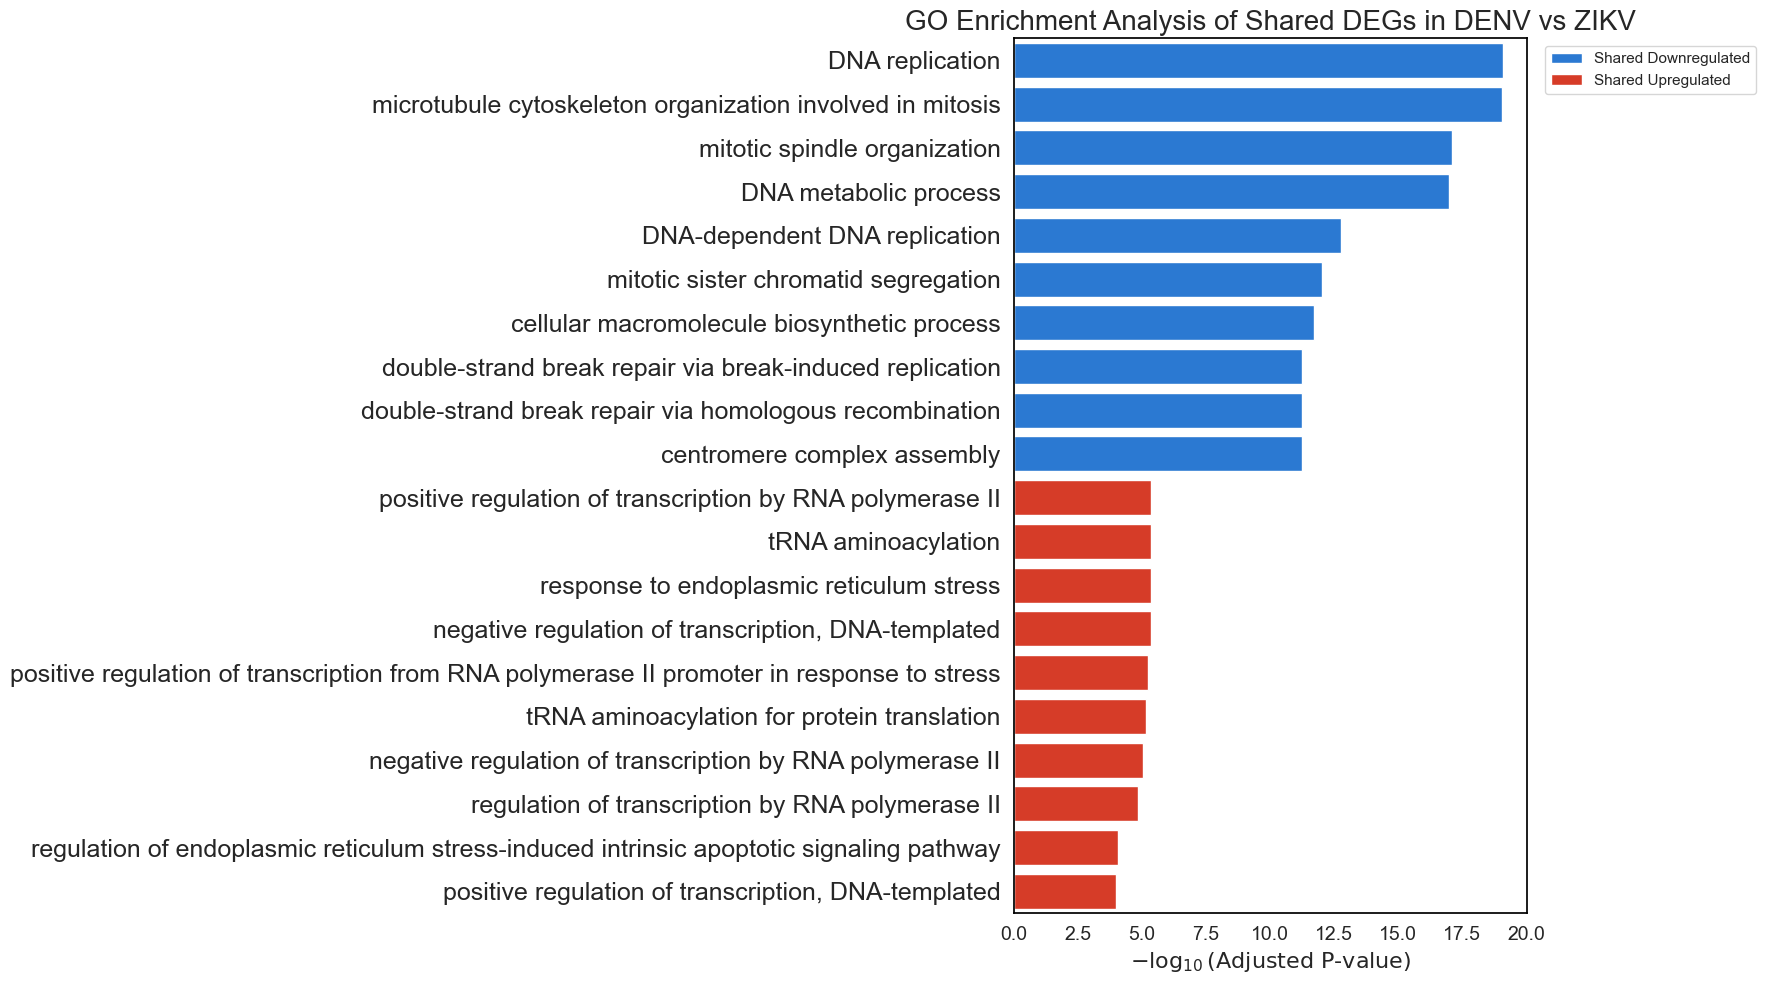

In [ ]:
# Load raw expression data 
denv = pd.read_csv("Dengue Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)
zikv = pd.read_csv("Zika Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)

# Select required columns and rename 
denv = denv[['Gene Symbol', 'log FC', 'adjusted p-val']].rename(
    columns={'log FC': 'logFC_DENV', 'adjusted p-val': 'adjP_DENV'}
)
zikv = zikv[['Gene Symbol', 'log FC', 'adjusted p-val']].rename(
    columns={'log FC': 'logFC_ZIKV', 'adjusted p-val': 'adjP_ZIKV'}
)

# Merge DENV and ZIKV datasets 
merged = pd.merge(denv, zikv, on='Gene Symbol').dropna()

# Filter for shared DEGs 
padj_thresh = 0.05
fc_thresh = 1.0

shared_up = merged[
    (merged['adjP_DENV'] < padj_thresh) & (merged['logFC_DENV'] > fc_thresh) &
    (merged['adjP_ZIKV'] < padj_thresh) & (merged['logFC_ZIKV'] > fc_thresh)
]

shared_down = merged[
    (merged['adjP_DENV'] < padj_thresh) & (merged['logFC_DENV'] < -fc_thresh) &
    (merged['adjP_ZIKV'] < padj_thresh) & (merged['logFC_ZIKV'] < -fc_thresh)
]

print(f"Shared Upregulated Genes: {len(shared_up)}")
print(f"Shared Downregulated Genes: {len(shared_down)}")

# Save the output
shared_up.to_csv("shared_up_DEGs.csv", index=False)
shared_down.to_csv("shared_down_DEGs.csv", index=False)

# Enrichment Input 
grouped_genes = {
    'Shared Upregulated': shared_up['Gene Symbol'].tolist(),
    'Shared Downregulated': shared_down['Gene Symbol'].tolist()
}

# GO Enrichment 
enriched_terms = []

for group, genes in grouped_genes.items():
    if len(genes) < 5:
        print(f"Skipping enrichment for {group} (only {len(genes)} genes)")
        continue

    enr = enrichr(
        gene_list=genes,
        gene_sets='GO_Biological_Process_2021',
        organism='Human',
        outdir=None
    )

    df = enr.results.copy()
    df = df.sort_values(by='Adjusted P-value').drop_duplicates(subset='Term').head(10)
    df['Adjusted P-value'] = df['Adjusted P-value'].replace(0, 1e-300)
    df['-log10(pval)'] = -np.log10(df['Adjusted P-value'])
    df['Group'] = group
    df['Term'] = df['Term'].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
    enriched_terms.append(df[['Term', '-log10(pval)', 'Group']])

# Combine for plotting 
plot_df = pd.concat(enriched_terms, ignore_index=True)
plot_df['Group'] = pd.Categorical(
    plot_df['Group'],
    categories=['Shared Downregulated', 'Shared Upregulated'],
    ordered=True
)
plot_df = plot_df.sort_values(by=['Group', '-log10(pval)'], ascending=[True, False])

# Plot 
custom_palette = {
    'Shared Downregulated': "#0F77EE",
    'Shared Upregulated': "#f3260b"
}

plt.figure(figsize=(18, 0.5 * len(plot_df)))
sns.set_style("whitegrid")
sns.set_context("notebook")

ax = sns.barplot(
    data=plot_df,
    y='Term',
    x='-log10(pval)',
    hue='Group',
    dodge=False,
    palette=custom_palette
)

plt.xlabel(r"$-\log_{10}(\mathrm{Adjusted\ P\text{-}value})$", fontsize=16)
plt.ylabel("", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.title("GO Enrichment Analysis of Shared DEGs in DENV vs ZIKV", fontsize=20)

# Aesthetic cleanup
for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')

ax.grid(False)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
for group, genes in grouped_genes.items():
    print(f"{group}: {len(genes)} genes")


Shared Upregulated: 42 genes
Shared Downregulated: 75 genes
UP-DENV & Down-ZIKV: 1 genes
Down-DENV & Up-ZIKV: 1 genes


Unique DEG counts:
DENV Upregulated: 2149
DENV Downregulated: 1173
ZIKV Upregulated: 42
ZIKV Downregulated: 41


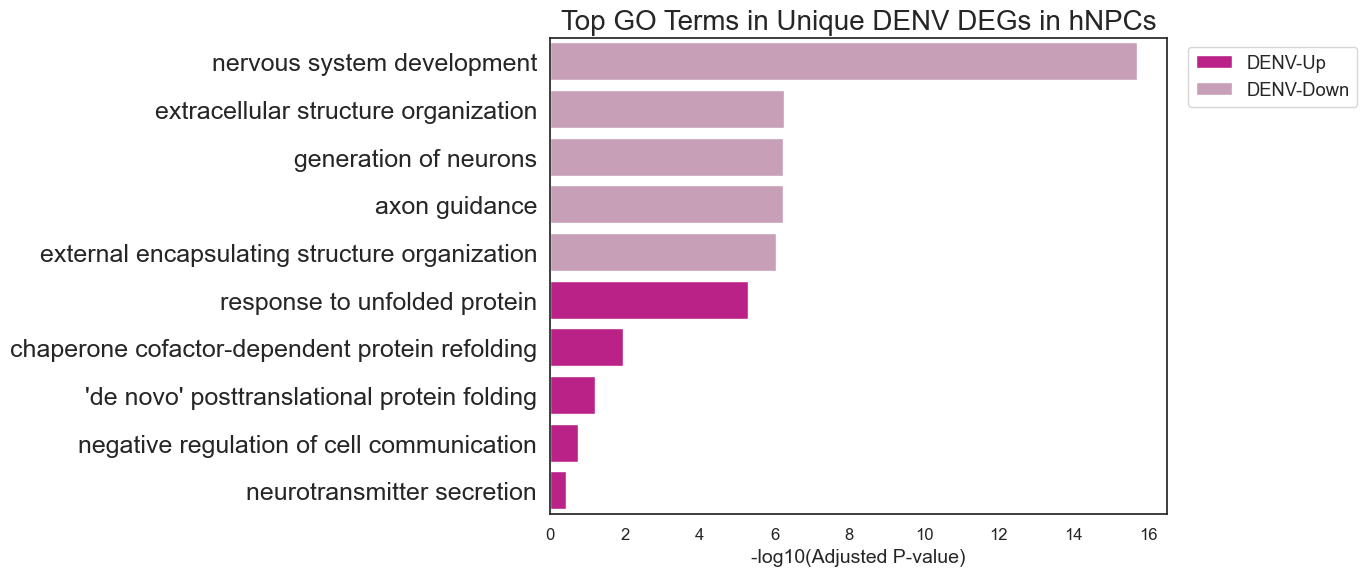

C:\Users\ruman\AppData\Local\Temp\ipykernel_17608\1596141408.py:81: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  plot_df['Term'] = plot_df['Term'].replace({


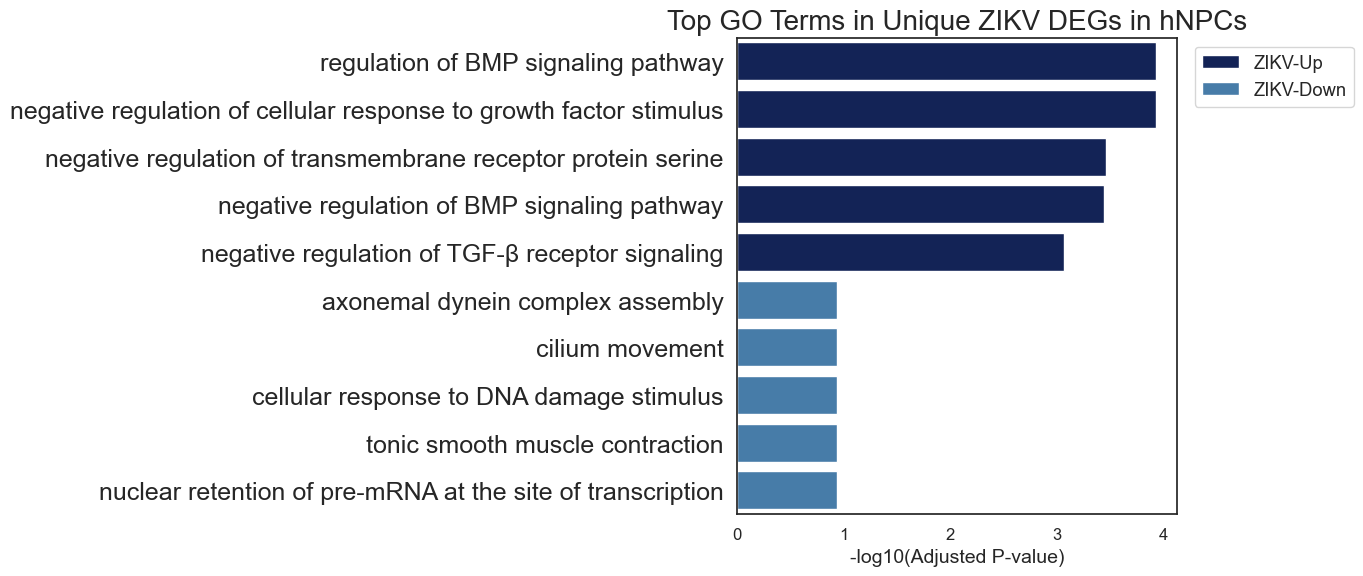

In [ ]:
# Unique DEGs in ZIKV and DENV

# Load raw DENV and ZIKV data
denv = pd.read_csv("Dengue Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)
zikv = pd.read_csv("Zika Neural stem cell_GSE80434.txt", sep="\t", skiprows=4)

# Set thresholds
padj_thresh = 0.05
fc_thresh = 1

# Classify DEGs

denv['Status'] = denv.apply(lambda x:
    'Up' if x['adjusted p-val'] < padj_thresh and x['log FC'] > fc_thresh else
    'Down' if x['adjusted p-val'] < padj_thresh and x['log FC'] < -fc_thresh else 'NS', axis=1)

zikv['Status'] = zikv.apply(lambda x:
    'Up' if x['adjusted p-val'] < padj_thresh and x['log FC'] > fc_thresh else
    'Down' if x['adjusted p-val'] < padj_thresh and x['log FC'] < -fc_thresh else 'NS', axis=1)

# Get DEG gene lists

denv_up = set(denv[denv['Status'] == 'Up']['Gene Symbol'])
denv_down = set(denv[denv['Status'] == 'Down']['Gene Symbol'])
zikv_up = set(zikv[zikv['Status'] == 'Up']['Gene Symbol'])
zikv_down = set(zikv[zikv['Status'] == 'Down']['Gene Symbol'])

# Identify unique DEGs

denv_unique_up = denv_up - zikv_up - zikv_down
denv_unique_down = denv_down - zikv_up - zikv_down
zikv_unique_up = zikv_up - denv_up - denv_down
zikv_unique_down = zikv_down - denv_up - denv_down

print("Unique DEG counts:")
print(f"DENV Upregulated: {len(denv_unique_up)}")
print(f"DENV Downregulated: {len(denv_unique_down)}")
print(f"ZIKV Upregulated: {len(zikv_unique_up)}")
print(f"ZIKV Downregulated: {len(zikv_unique_down)}")

# Function to run enrichment and plot
def enrich_and_plot(deg_groups, title):
    enriched_all = []
    for group, genes in deg_groups.items():
        if len(genes) < 5:
            continue
        enr = enrichr(
            gene_list=list(genes),
            gene_sets='GO_Biological_Process_2021',
            organism='Human',
            outdir=None
        )
        df = enr.results.copy()
        df = df.sort_values(by='Adjusted P-value').drop_duplicates(subset='Term').head(5)
        df['Adjusted P-value'] = df['Adjusted P-value'].replace(0, 1e-300)
        df['-log10(pval)'] = -np.log10(df['Adjusted P-value'])
        df['Group'] = group
        df['Term'] = df['Term'].str.replace(r"\s*\(GO:\d+\)", "", regex=True)
        enriched_all.append(df[['Term', '-log10(pval)', 'Group']])

    if not enriched_all:
        print(f"No enriched terms found for any group in {title}.")
        return

    plot_df = pd.concat(enriched_all, ignore_index=True)

    # Globally sort GO terms by enrichment (highest -log10(pval) on top)
    plot_df = plot_df.sort_values(by='-log10(pval)', ascending=False)
    plot_df['Term'] = pd.Categorical(plot_df['Term'], categories=plot_df['Term'].unique(), ordered=True)

    # Define group order for coloring
    group_order = [g for g in ['DENV-Up', 'DENV-Down', 'ZIKV-Up', 'ZIKV-Down'] if g in plot_df['Group'].unique()]
    plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_order, ordered=True)

    # Plot
    # Shorten long GO terms for better display
    plot_df['Term'] = plot_df['Term'].replace({
        "negative regulation of transmembrane receptor protein serine/threonine kinase signaling pathway":
            "negative regulation of transmembrane receptor protein serine",
        "negative regulation of transforming growth factor beta receptor signaling pathway":
            "negative regulation of TGF-β receptor signaling"
    })

    plt.figure(figsize=(14, 0.6 * len(plot_df)))
    sns.set_style("white")
    sns.set_context("notebook", font_scale=1.2)

    palette = {
        'DENV-Up': "#d30990",
        'DENV-Down': "#ce98b7",
        'ZIKV-Up': "#081d61",
        'ZIKV-Down': '#377eb8'
    }

    ax = sns.barplot(
        data=plot_df,
        y='Term',
        x='-log10(pval)',
        hue='Group',
        dodge=False,
        palette=palette
    )

    plt.xlabel("-log10(Adjusted P-value)", fontsize=14)
    plt.ylabel("")
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=18)

    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.grid(False)

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# DENV unique
enrich_and_plot({
    'DENV-Up': denv_unique_up,
    'DENV-Down': denv_unique_down
}, "Top GO Terms in Unique DENV DEGs in hNPCs")

# ZIKV unique
enrich_and_plot({
    'ZIKV-Up': zikv_unique_up,
    'ZIKV-Down': zikv_unique_down
}, "Top GO Terms in Unique ZIKV DEGs in hNPCs")


In [ ]:
# A summary table for a predefined list of genes 

# File paths — update these constants if your file names differ.
FPKM_CSV = Path('combined_fpkm_long.csv')
ZIKV_SUMMARY_TXT = Path('Zika Neural stem cell_GSE80434.txt')
DENV_SUMMARY_TXT = Path('Dengue Neural stem cell_GSE80434.txt')

# List of genes to include in the summary table.
GENES = [
    'CDK1', 'PCNA', 'AURKB', 'FANCD2', 'SQSTM1',
    'SLC3A2', 'ASNS', 'SLC7A5', 'SLC25A10'
]

def load_long_fpkm(path: Path) -> pd.DataFrame:
    """Load the long‑form FPKM table and map ZIKVC/ZIKVM to ZIKV."""
    df = pd.read_csv(path)
    df = df[df['gene_short_name'].isin(GENES)].copy()
    df['cond'] = df['condition'].replace({'ZIKVC': 'ZIKV', 'ZIKVM': 'ZIKV'})
    return df

def compute_fpkm_stats(df: pd.DataFrame) -> pd.DataFrame:
    """Compute mean and SD of FPKM for each gene and condition."""
    stats = (
        df.groupby(['gene_short_name', 'cond'])['FPKM']
        .agg(mean='mean', sd=lambda x: x.std(ddof=1))
        .reset_index()
    )
    stats = stats.rename(columns={'gene_short_name': 'Gene', 'cond': 'Condition', 'mean': 'Mean', 'sd': 'SD'})
    return stats

def load_summary_pvals(path: Path) -> pd.DataFrame:
    """Load a virus summary file and extract raw p-values."""
    df = pd.read_csv(path, sep='\t', comment='#')
    df = df[['Gene Symbol', 'raw p-val']].copy()
    df = df.rename(columns={'Gene Symbol': 'Gene', 'raw p-val': 'p_value'})
    df['Gene'] = df['Gene'].astype(str)
    return df.set_index('Gene')

def build_summary_table(fpkm_stats: pd.DataFrame,
                        zikv_pvals: pd.DataFrame,
                        denv_pvals: pd.DataFrame) -> pd.DataFrame:
    """Construct the final summary table with means, SDs and p-values."""
    rows = []
    for gene in GENES:
        cond_stats = fpkm_stats[fpkm_stats['Gene'] == gene].set_index('Condition')
        mock_mean = cond_stats.at['Mock', 'Mean'] if 'Mock' in cond_stats.index else float('nan')
        mock_sd   = cond_stats.at['Mock', 'SD']   if 'Mock' in cond_stats.index else float('nan')
        zikv_mean = cond_stats.at['ZIKV', 'Mean'] if 'ZIKV' in cond_stats.index else float('nan')
        zikv_sd   = cond_stats.at['ZIKV', 'SD']   if 'ZIKV' in cond_stats.index else float('nan')
        denv_mean = cond_stats.at['DENV', 'Mean'] if 'DENV' in cond_stats.index else float('nan')
        denv_sd   = cond_stats.at['DENV', 'SD']   if 'DENV' in cond_stats.index else float('nan')
        p_zikv = zikv_pvals.loc[gene, 'p_value'] if gene in zikv_pvals.index else float('nan')
        p_denv = denv_pvals.loc[gene, 'p_value'] if gene in denv_pvals.index else float('nan')
        rows.append({
            'Gene': gene,
            'Mock Mean': mock_mean,
            'Mock SD': mock_sd,
            'ZIKV Mean': zikv_mean,
            'ZIKV SD': zikv_sd,
            'DENV Mean': denv_mean,
            'DENV SD': denv_sd,
            'P (Mock vs ZIKV)': p_zikv,
            'P (Mock vs DENV)': p_denv,
        })
    result = pd.DataFrame(rows)
    return result

def main():
    fpkm_df = load_long_fpkm(FPKM_CSV)
    fpkm_stats = compute_fpkm_stats(fpkm_df)
    zikv_pvals = load_summary_pvals(ZIKV_SUMMARY_TXT)
    denv_pvals = load_summary_pvals(DENV_SUMMARY_TXT)
    summary_table = build_summary_table(fpkm_stats, zikv_pvals, denv_pvals)
    # Round numeric columns and format p-values
    for col in ['Mock Mean', 'Mock SD', 'ZIKV Mean', 'ZIKV SD', 'DENV Mean', 'DENV SD']:
        summary_table[col] = summary_table[col].round(2)
    summary_table['P (Mock vs ZIKV)'] = summary_table['P (Mock vs ZIKV)'].apply(lambda x: f"{x:.3e}" if pd.notna(x) else '')
    summary_table['P (Mock vs DENV)'] = summary_table['P (Mock vs DENV)'].apply(lambda x: f"{x:.3e}" if pd.notna(x) else '')
    summary_table.to_csv('genes_fpkm_summary_with_pvals.csv', index=False)
    print(summary_table.to_string(index=False))

if __name__ == '__main__':
    main()


    Gene  Mock Mean  Mock SD  ZIKV Mean  ZIKV SD  DENV Mean  DENV SD P (Mock vs ZIKV) P (Mock vs DENV)
    CDK1      43.75    18.53      15.27     6.16      19.80    15.08        1.265e-04        5.206e-05
    PCNA      84.92    43.78      30.39     9.37      38.16    26.09        2.043e-03        6.488e-04
   AURKB      26.53    11.16       8.56     3.74      13.34    11.36        1.449e-04        8.470e-05
  FANCD2       7.90     3.65       2.40     0.88       3.73     2.81        1.048e-03        1.057e-03
  SQSTM1      21.32     5.40      53.92    13.12      71.99    53.46        2.160e-04        2.043e-07
  SLC3A2      43.92     4.05     152.52    17.42     274.83   254.07        2.491e-05        4.650e-04
    ASNS      36.81     4.81     126.81    40.15     124.25    99.11        6.756e-04        2.183e-03
  SLC7A5      12.63     3.38      57.43    28.02      42.70    33.59        9.510e-03        3.542e-04
SLC25A10       4.04     1.31       1.71     0.28       2.38     1.01     

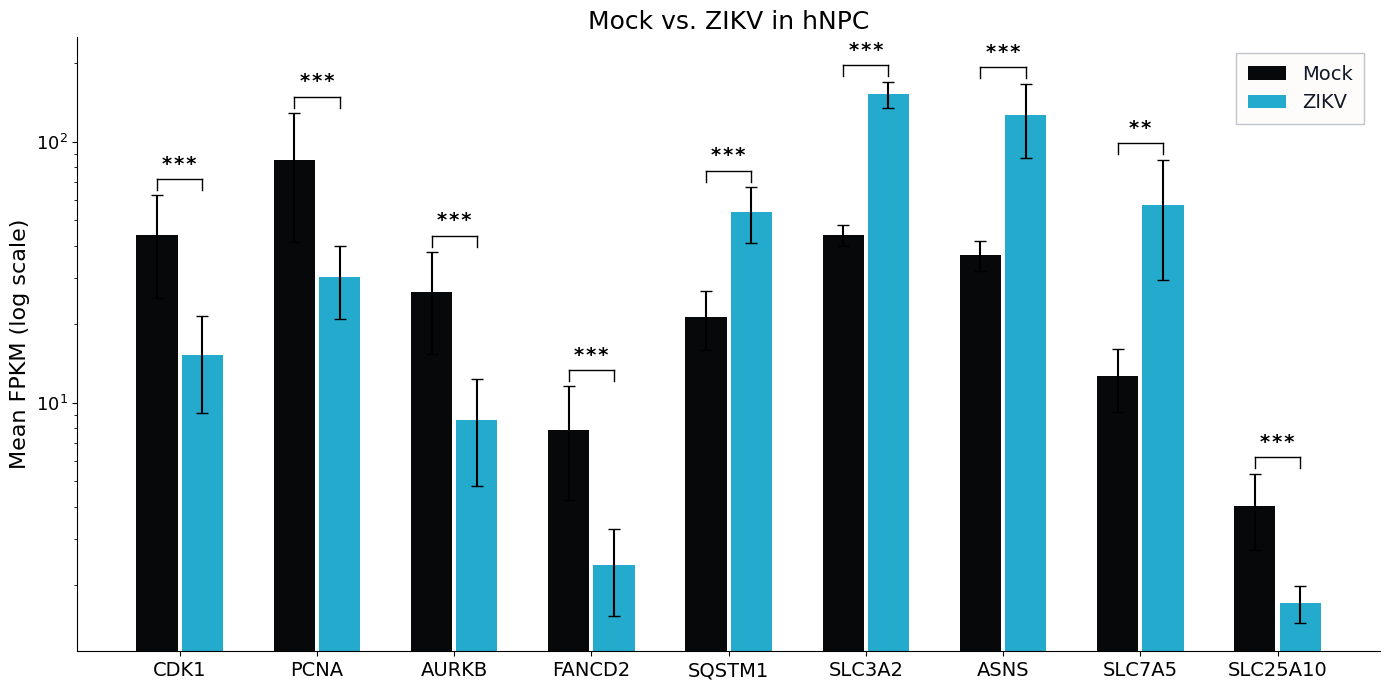

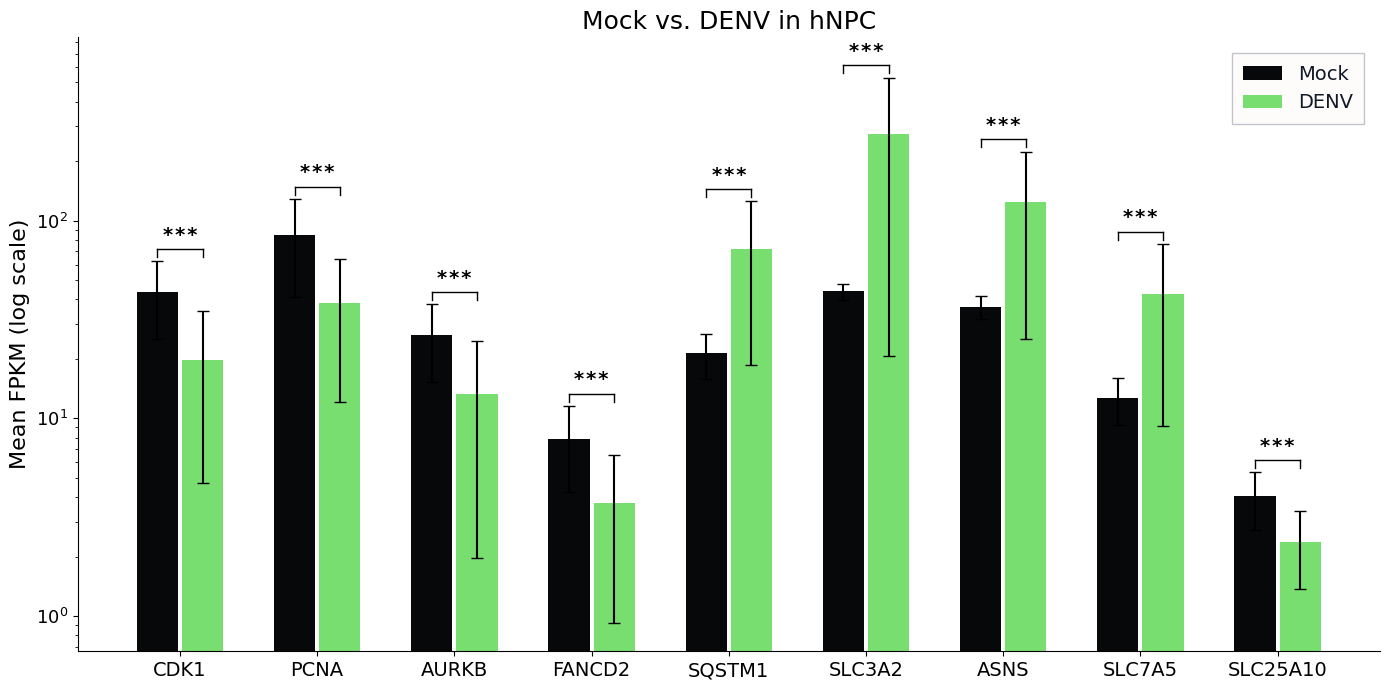

In [ ]:
# Load the summary table you already generated 
df = pd.read_csv("genes_fpkm_summary_with_pvals.csv")

# Robustly parse p-values (handles blanks)
p_zikv = pd.to_numeric(df['P (Mock vs ZIKV)'], errors='coerce').to_numpy()
p_denv = pd.to_numeric(df['P (Mock vs DENV)'], errors='coerce').to_numpy()

genes     = df['Gene'].tolist()
mock_mean = df['Mock Mean'].to_numpy()
mock_sd   = df['Mock SD'].to_numpy()
zikv_mean = df['ZIKV Mean'].to_numpy()
zikv_sd   = df['ZIKV SD'].to_numpy()
denv_mean = df['DENV Mean'].to_numpy()
denv_sd   = df['DENV SD'].to_numpy()

# Colors
bar_colors = {
    'Mock': "#06080a",  # black-ish
    'ZIKV': "#23AACC",  # cyan-ish
    'DENV': "#79de70"   # magenta
}

# Change legend box background and border
import matplotlib as mpl
mpl.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 13,
    "legend.fontsize": 14,        # text size
    "legend.frameon": True,       # show box
    "legend.framealpha": 1.0,     # opaque
    "legend.facecolor": "#FDFCFB",  # white background
    "legend.edgecolor": "#C1C4CA",  # black border
    "legend.fancybox": False,     # square corners 
    "legend.borderpad": 0.6,      # padding inside the box
    "legend.borderaxespad": 0.8,   # gap to the axes
    "legend.labelcolor":"#111827",  
})

# Star size
STAR_SIZE = 14

# Spacing character
STAR_SIZE = 14
HAIR_SPACE = "\u200A"           
def spaced(s): return HAIR_SPACE.join(s) if s else s

## Define stars 
def stars(p):
    if p is None or np.isnan(p): return ''
    if p < 0.005: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    return ''

def plot_mock_vs_virus(
    genes, mock_mean, mock_sd, virus_mean, virus_sd, pvals,
    virus_name, virus_color, outfile
):
    n = len(genes)
    x = np.arange(n)
    bar_width = 0.30
    inner_gap = 0.03 

    # Left (Mock) and right (Virus) bars with a gap around the center
    pos_mock  = x - (bar_width/2 + inner_gap/2)
    pos_virus = x + (bar_width/2 + inner_gap/2)

    fig, ax = plt.subplots(figsize=(14, 7))

    # Bars
    ax.bar(pos_mock,  mock_mean,  width=bar_width, yerr=mock_sd,  capsize=4,
           label='Mock', color=bar_colors['Mock'])
    ax.bar(pos_virus, virus_mean, width=bar_width, yerr=virus_sd, capsize=4,
           label=virus_name, color=virus_color)

    # Significance brackets (multiplicative spacing suits log-scale)
    for i, g in enumerate(genes):
        # Highest point among the pair (mean + sd)
        top = max(mock_mean[i] + mock_sd[i], virus_mean[i] + virus_sd[i])

        # On log scale, multiply for spacing above the tallest bar
        b_bot = top * 1.05
        b_top = b_bot * 1.10

        s = stars(pvals[i])
        if s:
            x1, x2 = pos_mock[i], pos_virus[i]
            # verticals
            ax.plot([x1, x1], [b_bot, b_top], lw=1.0, color='black')
            ax.plot([x2, x2], [b_bot, b_top], lw=1.0, color='black')
            # horizontal
            ax.plot([x1, x2], [b_top, b_top], lw=1.0, color='black')
            # stars
            ax.text((x1 + x2) / 2, b_top * 1.05, spaced(s),
            ha='center', va='bottom',
            fontsize=STAR_SIZE, fontweight='bold', color='black')

    # Axes/labels
    ax.set_xticks(x)
    ax.set_xticklabels(genes)
    ax.set_ylabel('Mean FPKM (log scale)')
    ax.set_title(f'Mock vs. {virus_name} in hNPC', fontsize=18)
    ax.legend()

    # Log scale and styling
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    plt.tight_layout()
    fig.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

# Plot 1: Mock vs ZIKV 
plot_mock_vs_virus(
    genes, mock_mean, mock_sd,
    zikv_mean, zikv_sd, p_zikv,
    virus_name='ZIKV',
    virus_color=bar_colors['ZIKV'],
    outfile='mock_vs_zikv.png'
)

# Plot 2: Mock vs DENV 
plot_mock_vs_virus(
    genes, mock_mean, mock_sd,
    denv_mean, denv_sd, p_denv,
    virus_name='DENV',
    virus_color=bar_colors['DENV'],
    outfile='mock_vs_denv.png'
)



[Series Matrix] Parsed samples (first few rows):
       gsm condition srr_list                 title
GSM2995091      Mock       []            Mock, Rep1
GSM2995092      Mock       []            Mock, Rep2
GSM2995093      Mock       []            Mock, Rep3
GSM2995094      DENV       [] Dengue Infected, Rep1
GSM2995095      DENV       [] Dengue Infected, Rep2
GSM2995096      DENV       [] Dengue Infected, Rep3

[Counts] First 8 sample columns: ['GSM2995091', 'GSM2995092', 'GSM2995093', 'GSM2995094', 'GSM2995095', 'GSM2995096']

[Matching] Mock columns found: ['GSM2995091', 'GSM2995092', 'GSM2995093']
[Matching] DENV columns found: ['GSM2995094', 'GSM2995095', 'GSM2995096']


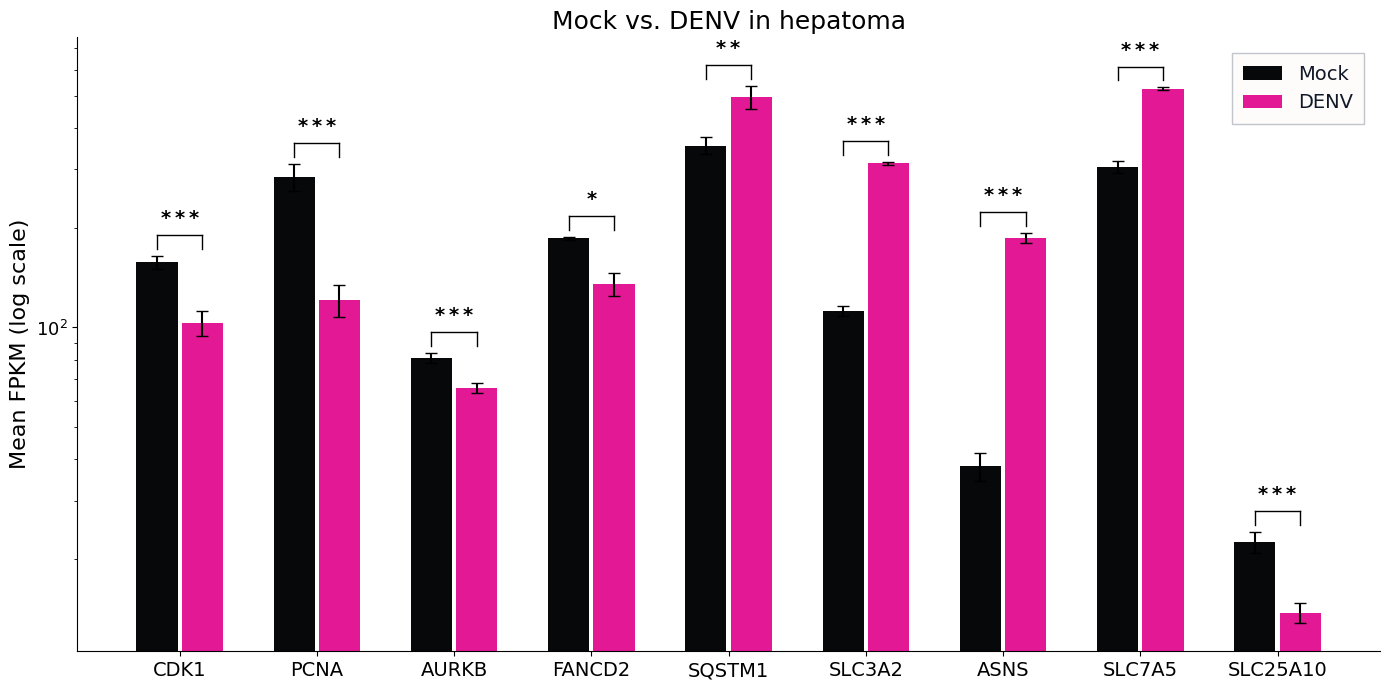

In [ ]:
# Mock vs DENV hepatoma
SERIES_MATRIX = "GSE110512_series_matrix.txt.gz"
RAW_COUNTS    = "GSE110512_raw_counts_GRCh38.p13_NCBI.tsv.gz"
ANNOT_TBL     = "Human.GRCh38.p13.annot.tsv.gz"

GENES = ['CDK1','PCNA','AURKB','FANCD2','SQSTM1','SLC3A2','ASNS','SLC7A5','SLC25A10']
FILTER_CELL_KEYWORDS = ['hepatoma','huh7']   
DEBUG_PRINT = True

mpl.rcParams.update({
    'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 13,
    "legend.fontsize": 13, "legend.frameon": True, "legend.framealpha": 1.0,
    "legend.facecolor": "white", "legend.edgecolor": "black", "legend.fancybox": True
})
COLORS = {'Mock': '#06080a', 'DENV': "#e31895"}

# Change legend box background + border
import matplotlib as mpl
mpl.rcParams.update({
    "legend.frameon": True,
    "legend.facecolor": "#FDFCFB",   # legend background
    "legend.edgecolor":  "#C1C4CA",  # border colour
    "legend.framealpha": 1.0,        # 1.0 = opaque
    "legend.fancybox":  False,       # square corners
    "legend.fontsize":  14,
    "legend.labelcolor":"#111827",   # legend text
})

# Star size
STAR_SIZE = 14 

# Spacing character
THIN_SPACE = "\u2009"   
# HAIR_SPACE = "\u200A" 
# NNBSP      = "\u202F" 

def spaced_stars(s: str) -> str:
    """Return '* * *' with even tiny gaps, or '' if s is empty."""
    return THIN_SPACE.join(s) if s else s

def _dequote_list(lst):
    return [re.sub(r'^"|"$', '', str(x)).strip() for x in lst]

def parse_series_matrix(path):
    """Return DataFrame with sample rows and inferred condition + IDs (GSM, SRR), stripping quotes."""
    with gzip.open(path, 'rt', encoding='utf-8', errors='ignore') as fh:
        lines = [ln.rstrip('\n') for ln in fh]

    cols = {}
    char_lines, relation_lines = [], []
    for ln in lines:
        if ln.startswith('!Sample_'):
            key, *vals = ln.split('\t')
            if key in ('!Sample_geo_accession', '!Sample_title', '!Sample_source_name_ch1'):
                cols[key] = vals
            elif key.startswith('!Sample_characteristics_ch1'):
                char_lines.append(vals)
            elif key == '!Sample_relation':
                relation_lines.append(vals)

    gsms = cols.get('!Sample_geo_accession', [])
    if not gsms:
        raise ValueError("No !Sample_geo_accession found in Series Matrix.")
    n = len(gsms)

    def pad(v): return v + ['']*(n - len(v))

    titles  = pad(cols.get('!Sample_title', []))
    sources = pad(cols.get('!Sample_source_name_ch1', []))
    chars   = ['']*n
    for v in char_lines:
        v = pad(v)
        chars = [f"{a} {b}".strip() for a,b in zip(chars, v)]
    rels    = ['']*n
    for v in relation_lines:
        v = pad(v)
        rels = [f"{a} {b}".strip() for a,b in zip(rels, v)]

    
    gsms   = _dequote_list(gsms)
    titles = _dequote_list(titles)
    sources= _dequote_list(sources)
    chars  = _dequote_list(chars)
    rels   = _dequote_list(rels)

    df = pd.DataFrame({
        'gsm': gsms, 'title': titles, 'source': sources, 'chars': chars, 'relations': rels
    })
    df['meta'] = (df['title'] + ' | ' + df['source'] + ' | ' + df['chars'] + ' | ' + df['relations']).str.lower()

    def infer_cond(s):
        if re.search(r'\bdenv\b|\bdengue\b', s): return 'DENV'
        if re.search(r'\bmock\b|\bcontrol\b|\buninfect', s): return 'Mock'
        return 'Other'
    df['condition'] = df['meta'].apply(infer_cond)

    # Extract SRR if present 
    def extract_srr(s): return re.findall(r'(SRR\d+)', s, flags=re.I)
    df['srr_list'] = df.apply(lambda r: list(dict.fromkeys(
        extract_srr(r['relations']) + extract_srr(r['chars']) + extract_srr(r['title'])
    )), axis=1)

    if FILTER_CELL_KEYWORDS:
        mask = df['meta'].apply(lambda s: any(k in s for k in FILTER_CELL_KEYWORDS))
        if mask.sum() == 0 and DEBUG_PRINT:
            print("[Info] No samples matched hepatoma/Huh7 filter. Using ALL samples.")
        else:
            df = df[mask].copy()

    df = df[df['condition'].isin(['Mock','DENV'])].reset_index(drop=True)

    if DEBUG_PRINT:
        print("\n[Series Matrix] Parsed samples (first few rows):")
        print(df[['gsm','condition','srr_list','title']].head(10).to_string(index=False))
    return df
# Helper
def load_counts(path):
    df = pd.read_csv(path, sep='\t', compression='infer')
    gene_col = next((c for c in df.columns if re.fullmatch(r'gene(id)?|gene_id|geneid|GeneID|Geneid|Gene', c, re.I)), df.columns[0])
    df = df.rename(columns={gene_col:'gene_id'})
    df['gene_id'] = df['gene_id'].astype(str).str.split('.', n=1).str[0]
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        for c in df.columns:
            if c != 'gene_id':
                df[c] = pd.to_numeric(df[c], errors='coerce')
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df = df[['gene_id'] + num_cols].fillna(0)
    if DEBUG_PRINT:
        print("\n[Counts] First 8 sample columns:", num_cols[:8])
    return df, num_cols

def load_annot(path):
    ann = pd.read_csv(path, sep='\t', compression='infer', low_memory=False)
    id_col  = next((c for c in ann.columns if re.fullmatch(r'gene_id|GeneID', c, re.I)), ann.columns[0])
    sym_col = next((c for c in ann.columns if re.search(r'(gene_)?name|symbol', c, re.I)), None)
    if sym_col is None:
        raise ValueError("No gene symbol column found in annotation.")
    ann = ann[[id_col, sym_col]].rename(columns={id_col:'gene_id', sym_col:'symbol'})
    ann['gene_id'] = ann['gene_id'].astype(str).str.split('.', n=1).str[0]
    ann['symbol']  = ann['symbol'].astype(str)
    return ann

def match_columns(sm, counts_cols):
    """Return (mock_cols, denv_cols) by matching GSM (exact/substring) and SRR."""
    counts_cols_set = set(counts_cols)

    # GSM exact + substring
    gsm2cols = {g:[g] for g in sm['gsm'] if g in counts_cols_set}
    for c in counts_cols:
        for g in sm['gsm']:
            if g in c:
                gsm2cols.setdefault(g, []).append(c)

    # SRR (rare in this series; keep for completeness)
    srrs = {s for lst in sm['srr_list'] for s in lst}
    srr2cols = {s:[s] for s in srrs if s in counts_cols_set}
    for c in counts_cols:
        for s in srrs:
            if s in c:
                srr2cols.setdefault(s, []).append(c)

    mock_cols, denv_cols = [], []
    for _, row in sm.iterrows():
        cols_for_sample = []
        cols_for_sample += gsm2cols.get(row['gsm'], [])
        for s in row['srr_list']:
            cols_for_sample += srr2cols.get(s, [])
        cols_for_sample = [c for c in dict.fromkeys(cols_for_sample)]
        if row['condition'] == 'Mock':
            mock_cols.extend(cols_for_sample)
        elif row['condition'] == 'DENV':
            denv_cols.extend(cols_for_sample)

    # Unique, preserve order
    mock_cols = [c for c in counts_cols if c in set(mock_cols)]
    denv_cols = [c for c in counts_cols if c in set(denv_cols)]

    if DEBUG_PRINT:
        print("\n[Matching] Mock columns found:", mock_cols)
        print("[Matching] DENV columns found:", denv_cols)

    return mock_cols, denv_cols

def to_cpm(df):
    lib = df.sum(axis=0).replace(0, np.nan)
    return df.divide(lib, axis=1) * 1e6

def stars(p):
    if p is None or np.isnan(p): return ''
    if p < 0.005: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return ''

# pipeline 
sm = parse_series_matrix(SERIES_MATRIX)
counts, counts_cols = load_counts(RAW_COUNTS)
annot = load_annot(ANNOT_TBL)

# Map Ensembl → symbol, collapse duplicates
counts = counts.merge(annot, on='gene_id', how='left').dropna(subset=['symbol'])
counts = counts.drop(columns=['gene_id']).groupby('symbol', as_index=False).sum()

# Match counts columns to conditions (GSM or SRR)
mock_cols, denv_cols = match_columns(sm, counts_cols)
if not mock_cols or not denv_cols:
    raise RuntimeError("Still could not identify Mock/DENV columns. "
                       "Check printed GSMs and counts columns above.")

# CPM per condition
cpm_mock = counts[['symbol'] + mock_cols].rename(columns={'symbol':'Gene'}).set_index('Gene')
cpm_denv = counts[['symbol'] + denv_cols].rename(columns={'symbol':'Gene'}).set_index('Gene')
cpm_mock = to_cpm(cpm_mock); cpm_denv = to_cpm(cpm_denv)

# Restrict to the 9 genes (case-insensitive)
genes_uc = [g.upper() for g in GENES]
cpm_mock.index = cpm_mock.index.str.upper()
cpm_denv.index = cpm_denv.index.str.upper()
cpm_mock = cpm_mock.reindex(genes_uc)
cpm_denv = cpm_denv.reindex(genes_uc)

# Summary + Welch t-test on log2(CPM+1)
mock_mean = cpm_mock.mean(axis=1).to_numpy()
mock_sd   = cpm_mock.std(axis=1, ddof=1).to_numpy()
denv_mean = cpm_denv.mean(axis=1).to_numpy()
denv_sd   = cpm_denv.std(axis=1, ddof=1).to_numpy()

try:
    from scipy.stats import ttest_ind
    pvals = []
    for i in range(len(genes_uc)):
        x = np.log2(cpm_mock.iloc[i].to_numpy() + 1.0)
        y = np.log2(cpm_denv.iloc[i].to_numpy() + 1.0)
        pvals.append(ttest_ind(x, y, equal_var=False, nan_policy='omit').pvalue)
    pvals = np.array(pvals)
except Exception:
    pvals = np.full(len(genes_uc), np.nan)

# plot 
n = len(GENES); x = np.arange(n); bw = 0.30; gap = 0.03
pos_m = x - (bw/2 + gap/2); pos_d = x + (bw/2 + gap/2)
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(pos_m, mock_mean, width=bw, yerr=mock_sd, capsize=4, label='Mock', color=COLORS['Mock'])
ax.bar(pos_d, denv_mean, width=bw, yerr=denv_sd, capsize=4, label='DENV', color=COLORS['DENV'])

for i in range(n):
    top = np.nanmax([mock_mean[i] + (mock_sd[i] if np.isfinite(mock_sd[i]) else 0),
                     denv_mean[i] + (denv_sd[i] if np.isfinite(denv_sd[i]) else 0)])
    if not np.isfinite(top) or top <= 0: continue
    b1, b2 = top*1.05, top*1.155
    s = stars(pvals[i])
    if s:
        ax.plot([pos_m[i], pos_m[i]], [b1, b2], lw=1, color='black')
        ax.plot([pos_d[i], pos_d[i]], [b1, b2], lw=1, color='black')
        ax.plot([pos_m[i], pos_d[i]], [b2, b2], lw=1, color='black')
        ax.text((pos_m[i] + pos_d[i]) / 2, b2 * 1.05, spaced_stars(s),
        ha='center', va='bottom',
        fontsize=STAR_SIZE, fontweight='bold', color='black')

ax.set_xticks(x); ax.set_xticklabels(GENES)
ax.set_ylabel('Mean FPKM (log scale)')
ax.set_title('Mock vs. DENV in hepatoma', fontsize=18)
ax.legend(); ax.set_yscale('log')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(False)
fig.tight_layout(); fig.savefig('mock_vs_denv_hepatoma_from_files.png', dpi=300, bbox_inches='tight')
plt.show()

# Save summary
pd.DataFrame({
    'Gene': GENES,
    'Mock Mean CPM': mock_mean, 'Mock SD CPM': mock_sd,
    'DENV Mean CPM': denv_mean, 'DENV SD CPM': denv_sd,
    'P (Mock vs DENV)': pvals
}).to_csv('hepatoma_denv_gene_summary_from_files.csv', index=False)


# Save to PDF

In [9]:
# 1) Ensure webpdf + Playwright are installed
!pip install -q "nbconvert[webpdf]" playwright

# 2) Download the Chromium browser that Playwright needs (one-time)
!playwright install chromium

# 3) Export your notebook to PDF
!jupyter nbconvert "Neural_Cell_Analysis.ipynb" --to webpdf --output "Neural_Cell_Analysis"



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


|                                                                                |   0% of 137.1 MiB
|■■■■■■■■                                                                        |  10% of 137.1 MiB
|■■■■■■■■■■■■■■■■                                                                |  20% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■                                                        |  30% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■                                                |  40% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■                                        |  50% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■                                |  60% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■                        |  70% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■                |  80% of 137.1 MiB
|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■        |  90% of 

[NbConvertApp] Converting notebook Neural_Cell_Analysis.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1150125 bytes to Neural_Cell_Analysis.pdf


In [10]:
!jupyter nbconvert "Neural_Cell_Analysis.ipynb" --to webpdf \
  --WebPDFExporter.allow_chromium_download=True \
  --output "Neural_Cell_Analysis"


[NbConvertApp] Converting notebook Neural_Cell_Analysis.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1150125 bytes to Neural_Cell_Analysis.pdf


In [ ]:
# import os, glob, pathlib

# 1) Where did nbconvert write to?
print("CWD:", os.getcwd())

# 2) List PDFs right there
print("PDFs here:", glob.glob("*.pdf"))

# 3) If still not obvious, search your home folder
for p in pathlib.Path.home().rglob("Neural_Cell_Analysis.pdf"):
    print("Found:", p)


CWD: c:\Users\ruman\Desktop\Project 2025\1. Final SUBMISSION
PDFs here: ['Neural_Cell_Analysis.pdf']
Found: C:\Users\ruman\Desktop\Project 2025\1. Final SUBMISSION\Neural_Cell_Analysis.pdf
